In [1]:
import random
from collections import Counter
from multiprocessing import Pool, cpu_count
from typing import Dict, List, Set, Tuple

import networkx as nx
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from icm_diffusion import simulate_diffusion_ICM
from src.graph import (
    create_polarized_graph,
    create_polarized_graph_multiple,
    graph_loader,
    random_color_graph,
    spectral_bipartition_coloring,
    spectral_partition_coloring,
    k_means_partition_coloring
)
from src.seed import seed_degree, seed_mia, seed_polarized, seed_random


In [2]:
import warnings

# Suppress the specific UserWarning from sklearn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.manifold._spectral_embedding")

In [3]:
from edge_addition import (
    edge_addition_custom,
    edge_addition_adamic_adar,
    edge_addition_preferential_attachment,
    edge_addition_jaccard,
    edge_addition_degree,
    edge_addition_topk,
    edge_addition_prob,
    edge_addition_kkt,
    edge_addition_random,
)

In [4]:
# Function to evaluate and compare the graph modifications

def evaluate_graph_modifications(G, seeds, k, max_iter, budget):
    # Simulate diffusion on the original graph
    original_results_dict = simulate_diffusion_ICM(G, seeds, max_iter)

    # Extract original results
    original_results = pd.DataFrame(
        {
            "Metric": [
                "Avg Activated Nodes",
                "Activated Nodes Std Dev",
                "Avg Color Activation Count",
                "Color Activation Count Std Dev",
            ],
            "Original Graph": [
                round(original_results_dict["avg_activated_nodes"], 3),
                round(original_results_dict["std_dev_activated_nodes"], 3),
                round(original_results_dict["avg_color_activation_count"], 3),
                round(original_results_dict["std_dev_color_activation_count"], 3),
            ],
        }
    )

    # Get the number of nodes and edges for all graphs
    graph_info = {
        "Metric": ["Number of Nodes", "Number of Edges"],
        "Original Graph": [G.number_of_nodes(), G.number_of_edges()],
    }

    # Define a list of modification functions
    #"Prob": edge_addition_prob,
    modification_functions = {
        "PrefAtt": edge_addition_preferential_attachment,
        "Jaccard": edge_addition_jaccard,
        "Degree": edge_addition_degree,
        "TopK": edge_addition_topk,
        "KKT": edge_addition_kkt,
        "Random": edge_addition_random,
        "Custom": edge_addition_custom,
    }

    combined_results = original_results.copy()

    # Evaluate each graph modification
    for method_name, mod_func in modification_functions.items():
        modified_graph = mod_func(G, seeds, k, budget)
        modified_results_dict = simulate_diffusion_ICM(modified_graph, seeds, max_iter)

        adapted_results = pd.DataFrame(
            {
                "Metric": [
                    "Avg Activated Nodes",
                    "Activated Nodes Std Dev",
                    "Avg Color Activation Count",
                    "Color Activation Count Std Dev",
                ],
                f"Adapted Graph {method_name}": [
                    round(modified_results_dict["avg_activated_nodes"], 3),
                    round(modified_results_dict["std_dev_activated_nodes"], 3),
                    round(modified_results_dict["avg_color_activation_count"], 3),
                    round(modified_results_dict["std_dev_color_activation_count"], 3),
                ],
            }
        )

        combined_results = pd.merge(combined_results, adapted_results, on="Metric")
        graph_info[f"Adapted Graph {method_name}"] = [
            modified_graph.number_of_nodes(),
            modified_graph.number_of_edges(),
        ]

    graph_info_df = pd.DataFrame(graph_info)

    # Combine all results into one DataFrame
    final_results = pd.concat([graph_info_df, combined_results], ignore_index=True)

    # Transpose the DataFrame and set the first row as the header
    final_results = final_results.T
    final_results.columns = final_results.iloc[
        0
    ]  # Set the first row as the column names
    final_results = final_results.drop(final_results.index[0])  # Drop the first row

    return final_results


In [5]:
num_groups = 4

G = create_polarized_graph_multiple(1000, num_groups, 0.05, 0.0005)
#G = graph_loader("datasets/facebook/facebook_combined.txt")
#G = graph_loader('datasets/congress_network/congress.edgelist')

spectral_partition_coloring(G, num_groups)
colors = plt.cm.get_cmap('tab10', num_groups)  # Use 'tab10' colormap to get distinct colors
color_map = [colors(G.nodes[node]["color"]) for node in G.nodes()]
print(', '.join([f"Color {i+1}: {value}" for i, value in enumerate(list(Counter(color_map).values()))]))

Color 1: 250, Color 2: 250, Color 3: 250, Color 4: 250


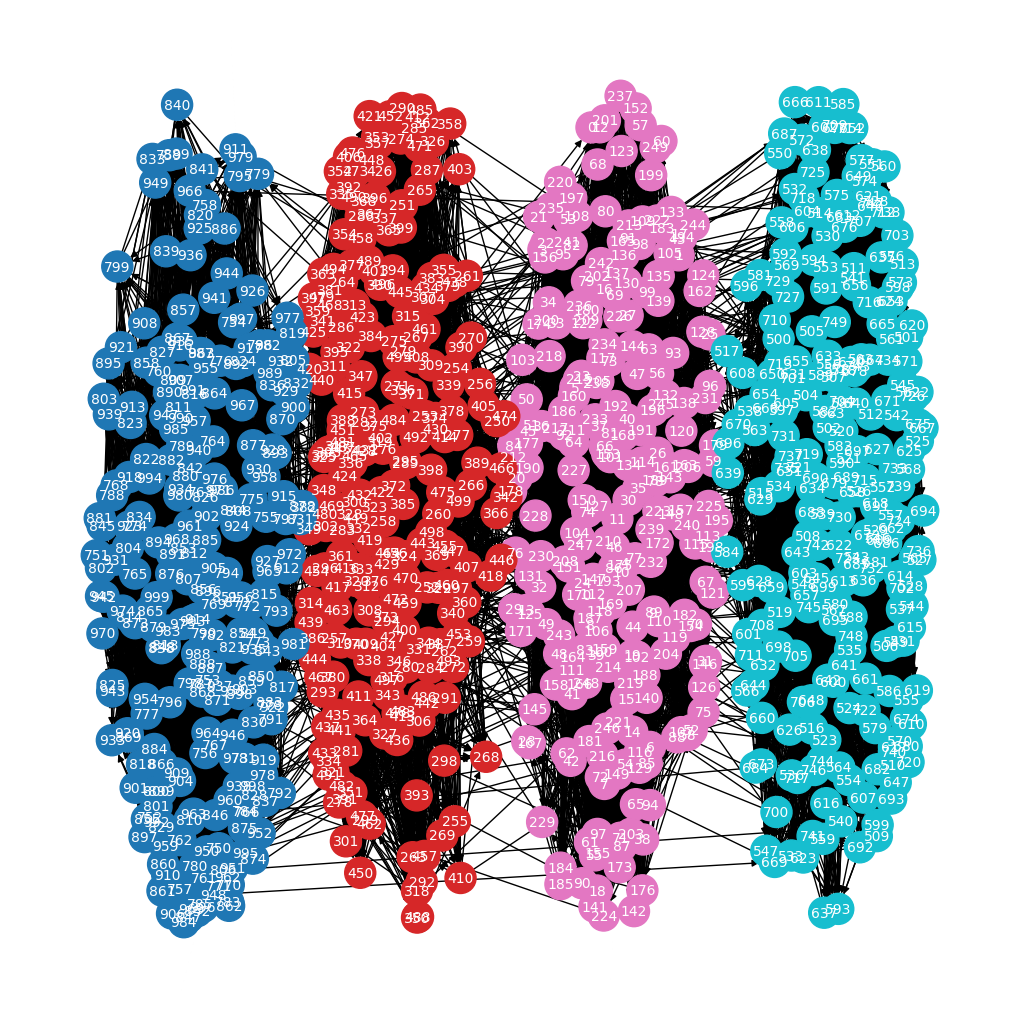

In [6]:
def draw_colored_graph(G, num_groups):
    """Draw a graph with nodes colored based on their group attribute and positioned accordingly."""
    
    # Generate a color map with different colors for each group
    colors = plt.cm.get_cmap('tab10', num_groups)  # Use 'tab10' colormap to get distinct colors
    color_map = [colors(G.nodes[node]["color"]) for node in G.nodes()]
    
    # Create a layout that encourages nodes of the same group to be closer together
    pos = nx.spring_layout(G, k=0.3, seed=42)  # Adjust 'k' to control the spacing between groups
    
    # Adjust positions manually to separate the groups
    group_offset = 2  # Define the offset distance between groups
    group_centers = {i: (group_offset * i, 0) for i in range(num_groups)}  # Center for each group
    
    for node, (x, y) in pos.items():
        group = G.nodes[node]["color"]
        group_center_x, group_center_y = group_centers[group]
        pos[node] = (x + group_center_x, y + group_center_y)
    
    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_color='white', font_size=10)
    
    # Display the graph
    plt.show()


draw_colored_graph(G, 4)

In [7]:
seed_size = 100
k = seed_size
max_iter = 1000
budget = 3 * seed_size

In [8]:
seed = seed_mia(G, seed_size)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
print("Results for MIA")
final_results

100%|██████████| 1000/1000 [00:01<00:00, 739.39it/s]

Results for MIA


Metric,Number of Nodes,Number of Edges,Avg Activated Nodes,Activated Nodes Std Dev,Avg Color Activation Count,Color Activation Count Std Dev
Original Graph,1000.0,12642.0,195.05,81.163,6.847,7.179
Adapted Graph PrefAtt,1000.0,12942.0,253.886,117.282,23.957,19.838
Adapted Graph Jaccard,1000.0,12942.0,212.696,91.97,8.673,8.203
Adapted Graph Degree,1000.0,12942.0,275.902,133.764,24.217,19.211
Adapted Graph TopK,1000.0,12942.0,224.601,107.26,19.445,18.225
Adapted Graph KKT,1000.0,12942.0,235.993,115.15,20.892,19.379
Adapted Graph Random,1000.0,12942.0,268.793,129.32,27.987,21.929
Adapted Graph Custom,1000.0,12942.0,255.216,112.571,31.337,25.488


In [9]:
seed = seed_polarized(G, seed_size, 0)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
print("Results for Polarized seed")
final_results

100%|██████████| 1000/1000 [00:01<00:00, 721.94it/s]

Results for Polarized seed


Metric,Number of Nodes,Number of Edges,Avg Activated Nodes,Activated Nodes Std Dev,Avg Color Activation Count,Color Activation Count Std Dev
Original Graph,1000.0,12642.0,189.85,75.173,6.53,6.791
Adapted Graph PrefAtt,1000.0,12942.0,247.017,118.265,23.072,18.986
Adapted Graph Jaccard,1000.0,12942.0,211.515,87.519,9.233,8.43
Adapted Graph Degree,1000.0,12942.0,281.658,136.861,26.463,21.512
Adapted Graph TopK,1000.0,12942.0,224.846,107.441,18.481,17.104
Adapted Graph KKT,1000.0,12942.0,233.629,114.636,20.951,19.634
Adapted Graph Random,1000.0,12942.0,262.302,121.061,27.944,21.719
Adapted Graph Custom,1000.0,12942.0,250.147,112.158,30.991,26.133


In [10]:
seed = seed_random(G, seed_size)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
print("Results for Random seed")
final_results

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 497.22it/s]

Results for Random seed


Metric,Number of Nodes,Number of Edges,Avg Activated Nodes,Activated Nodes Std Dev,Avg Color Activation Count,Color Activation Count Std Dev
Original Graph,1000.0,12642.0,325.099,167.241,9.327,8.081
Adapted Graph PrefAtt,1000.0,12942.0,346.142,172.81,23.203,18.443
Adapted Graph Jaccard,1000.0,12942.0,365.598,168.134,26.815,20.472
Adapted Graph Degree,1000.0,12942.0,363.455,171.488,25.981,20.782
Adapted Graph TopK,1000.0,12942.0,341.675,168.152,22.382,18.809
Adapted Graph KKT,1000.0,12942.0,345.622,171.25,20.864,18.015
Adapted Graph Random,1000.0,12942.0,356.493,167.095,27.798,20.856
Adapted Graph Custom,1000.0,12942.0,350.198,169.515,25.652,19.458


In [11]:
seed = seed_degree(G, seed_size)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
print("Results for Degree seed")
final_results

100%|██████████| 1000/1000 [00:01<00:00, 516.86it/s]

Results for Degree seed


Metric,Number of Nodes,Number of Edges,Avg Activated Nodes,Activated Nodes Std Dev,Avg Color Activation Count,Color Activation Count Std Dev
Original Graph,1000.0,12642.0,297.578,165.887,8.3,8.181
Adapted Graph PrefAtt,1000.0,12942.0,316.792,162.802,23.911,19.731
Adapted Graph Jaccard,1000.0,12942.0,346.647,172.8,27.71,21.506
Adapted Graph Degree,1000.0,12942.0,325.777,172.173,19.125,15.504
Adapted Graph TopK,1000.0,12942.0,317.416,170.868,19.101,18.894
Adapted Graph KKT,1000.0,12942.0,292.79,167.643,7.992,8.284
Adapted Graph Random,1000.0,12942.0,321.489,164.229,26.769,23.956
Adapted Graph Custom,1000.0,12942.0,325.142,168.401,24.494,21.887
